In [1]:
import mxnet as mx
path='http://data.mxnet.io/models/imagenet/'
[mx.test_utils.download(path+'squeezenet/squeezenet_v1.1-0000.params'),
 mx.test_utils.download(path+'squeezenet/squeezenet_v1.1-symbol.json')]

['squeezenet_v1.1-0000.params', 'squeezenet_v1.1-symbol.json']

Next, we load the downloaded model. 

In [2]:
# set the context on CPU
ctx = mx.cpu()

In [3]:
sym, arg_params, aux_params = mx.model.load_checkpoint('squeezenet_v1.1', 0)
mod = mx.mod.Module(symbol=sym, context=ctx, label_names=None)
mod.bind(for_training=False, data_shapes=[('data', (1,3,224,224))], 
         label_shapes=mod._label_shapes)
mod.set_params(arg_params, aux_params, allow_missing=True)

## Predicting

We first define helper functions for downloading an image and performing the
prediction:

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
# define a simple data batch
from collections import namedtuple
Batch = namedtuple('Batch', ['data'])

def get_image(url, show=False):
    # download and show the image. Remove query string from the file name.
    fname = mx.test_utils.download(url, fname=url.split('/')[-1].split('?')[0])
    img = mx.image.imread(fname)
    if img is None:
        return None
    if show:
        plt.imshow(img.asnumpy())
        plt.axis('off')
    # convert into format (batch, RGB, width, height)
    img = mx.image.imresize(img, 224, 224) # resize
    img = img.transpose((2, 0, 1)) # Channel first
    img = img.expand_dims(axis=0) # batchify
    img = img.astype('float32') # for gpu context
    return img

def predict(url):
    img = get_image(url, show=True)
    # compute the predict probabilities
    mod.forward(Batch([img]))
    prob = mod.get_outputs()[0].asnumpy()
    # print the top-5
    prob = np.squeeze(prob)
    a = np.argsort(prob)[::-1]
    for i in a[0:5]:
        print('probability=%f, class=%s' %(prob[i], labels[i]))

Now, we can perform prediction with any downloadable URL:

## Feature extraction

By feature extraction, we mean presenting the input images by the output of an internal layer rather than the last softmax layer. These outputs, which can be viewed as the feature of the raw input image, can then be used by other applications such as object detection.

We can use the ``get_internals`` method to get all internal layers from a Symbol.

In [5]:
# list the last 10 layers
all_layers = sym.get_internals()
all_layers.list_outputs()[-10:]

['fire9_concat_output',
 'drop9_output',
 'conv10_weight',
 'conv10_bias',
 'conv10_output',
 'relu_conv10_output',
 'pool10_output',
 'flatten_output',
 'prob_label',
 'prob_output']

In [6]:
fe_sym = all_layers['flatten_output']
fe_mod = mx.mod.Module(symbol=fe_sym, context=ctx, label_names=None)
fe_mod.bind(for_training=False, data_shapes=[('data', (1,3,224,224))])
fe_mod.set_params(arg_params, aux_params)

We can now invoke `forward` to obtain the features:

In [7]:
def get_features(img):
    fe_mod.forward(Batch([mx.nd.array(img)]))
    features=fe_mod.get_outputs()[0].asnumpy()
    return features

### 2nd part

In [8]:
# from https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data
from os import listdir
from os.path import isfile,join
import os

mypath = join(os.getcwd(),'cats vs dogs')

cats_imgs=[join(mypath,f) for f in listdir(mypath) if f.startswith('cat')]
dogs_imgs=[join(mypath,f) for f in listdir(mypath) if f.startswith('dog')]

In [9]:
print("cats: {} and dogs: {}".format(len(cats_imgs),len(dogs_imgs)))

cats: 12500 and dogs: 12500


In [10]:
Nmax=100
cats_features=[get_features(get_image(img)).ravel() for img in cats_imgs[:Nmax]]
dogs_features=[get_features(get_image(img)).ravel() for img in dogs_imgs[:Nmax]]

In [11]:
Y_cats=np.array(Nmax*[1])
Y_dogs=np.array(Nmax*[0])

In [12]:
X_cvd=np.vstack([cats_features,dogs_features])
Y_cvd=np.vstack([Y_cats,Y_dogs]).ravel()


In [13]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X_cvd,Y_cvd,random_state=42)

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [15]:
param_grid = [
{'penalty': ['l1'],'C': np.linspace(0.0001, 10, 5 )},
{'penalty': ['l2'],'C': np.linspace(0.0001, 10, 5 )}]


<!-- INSERT SOURCE DOWNLOAD BUTTONS -->


In [16]:
grid_bin = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid_bin.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'penalty': ['l1'], 'C': array([1.00000e-04, 2.50008e+00, 5.00005e+00, 7.50002e+00, 1.00000e+01])}, {'penalty': ['l2'], 'C': array([1.00000e-04, 2.50008e+00, 5.00005e+00, 7.50002e+00, 1.00000e+01])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [17]:
print("Test set score: {:.2f}".format(grid_bin.score(X_test,y_test)))

Test set score: 0.96


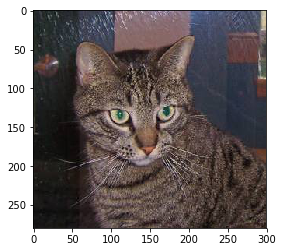

In [18]:
import matplotlib.image as mpimg
cat_test_path=join(os.getcwd(),'cats vs dogs\cat.1.jpg')
dog_test_path=join(os.getcwd(),'cats vs dogs\dog.1.jpg')
img=mpimg.imread(cat_test_path)
imgplot=plt.imshow(img)
plt.show()

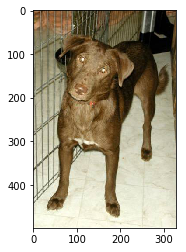

In [19]:
img=mpimg.imread(dog_test_path)
imgplot=plt.imshow(img)
plt.show()

In [20]:
features_out=get_features(get_image(cat_test_path))
prob=grid_bin.predict_proba(features_out)
pred=grid_bin.predict(features_out)

if pred[0]==1:
    fpred='cat'
else:
    fpred='dog'

print("prob: {} and prediction: {}".format(prob,fpred))

prob: [[3.73672204e-11 1.00000000e+00]] and prediction: cat


In [21]:
Nmax_1=1000
cats_features_1=[get_features(get_image(img)).ravel() for img in cats_imgs[:Nmax_1]]
dogs_features_1=[get_features(get_image(img)).ravel() for img in dogs_imgs[:Nmax_1]]

In [22]:
Y_cats_1=np.array(Nmax_1*[1])
Y_dogs_1=np.array(Nmax_1*[0])

In [23]:
X_cvd_1=np.vstack([cats_features_1,dogs_features_1])
Y_cvd_1=np.vstack([Y_cats_1,Y_dogs_1]).ravel()

In [24]:
from sklearn.model_selection import train_test_split
X1_train,X1_test,y1_train,y1_test=train_test_split(X_cvd_1,Y_cvd_1,random_state=42)

In [25]:
grid_bin = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid_bin.fit(X1_train, y1_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'penalty': ['l1'], 'C': array([1.00000e-04, 2.50008e+00, 5.00005e+00, 7.50002e+00, 1.00000e+01])}, {'penalty': ['l2'], 'C': array([1.00000e-04, 2.50008e+00, 5.00005e+00, 7.50002e+00, 1.00000e+01])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [26]:
print("Test set score: {:.2f}".format(grid_bin.score(X1_test,y1_test)))

Test set score: 0.95


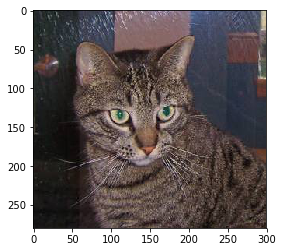

In [27]:
import matplotlib.image as mpimg
cat_test_path=join(os.getcwd(),'cats vs dogs\cat.1.jpg')
dog_test_path=join(os.getcwd(),'cats vs dogs\dog.1.jpg')
img=mpimg.imread(cat_test_path)
imgplot=plt.imshow(img)
plt.show()

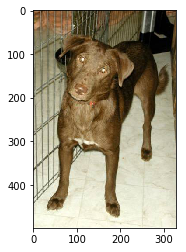

In [28]:
img=mpimg.imread(dog_test_path)
imgplot=plt.imshow(img)
plt.show()

In [29]:
features_out=get_features(get_image(cat_test_path))
prob=grid_bin.predict_proba(features_out)
pred=grid_bin.predict(features_out)

if pred[0]==1:
    fpred='cat'
else:
    fpred='dog'

print("prob: {} and prediction: {}".format(prob,fpred))

prob: [[9.34218687e-04 9.99065781e-01]] and prediction: cat


In [ ]:
Nmax_2=5000
cats_features_2=[get_features(get_image(img)).ravel() for img in cats_imgs[:Nmax_2]]
dogs_features_2=[get_features(get_image(img)).ravel() for img in dogs_imgs[:Nmax_2]]

In [ ]:
Y_cats_2=np.array(Nmax_2*[1])
Y_dogs_2=np.array(Nmax_2*[0])

In [ ]:
X_cvd_2=np.vstack([cats_features_2,dogs_features_2])
Y_cvd_2=np.vstack([Y_cats_2,Y_dogs_2]).ravel()

In [ ]:
from sklearn.model_selection import train_test_split
X2_train,X2_test,y2_train,y2_test=train_test_split(X_cvd_2,Y_cvd_2,random_state=42)

In [ ]:
grid_bin_2 = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid_bin_2.fit(X2_train, y2_train)

In [ ]:
print("Test set score: {:.2f}".format(grid_bin_2.score(X2_test,y2_test)))

In [ ]:
features_out_1=get_features(get_image(cat_test_path))
prob_1=grid_bin.predict_proba(features_out_1)
pred_1=grid_bin.predict(features_out_1)

if pred[0]==1:
    fpred='cat'
else:
    fpred='dog'

print("prob: {} and prediction: {}".format(prob_1,fpred))

In [ ]:
Nmax_3=12500
cats_features_3=[get_features(get_image(img)).ravel() for img in cats_imgs[:Nmax_3]]
dogs_features_3=[get_features(get_image(img)).ravel() for img in dogs_imgs[:Nmax_3]]

In [ ]:
Y_cats_3=np.array(Nmax_3*[1])
Y_dogs_3=np.array(Nmax_3*[0])

In [ ]:
X_cvd_3=np.vstack([cats_features_3,dogs_features_3])
Y_cvd_3=np.vstack([Y_cats_3,Y_dogs_3]).ravel()

In [ ]:

X3_train,X3_test,y3_train,y3_test=train_test_split(X_cvd_3,Y_cvd_3,random_state=42)

In [ ]:
grid_bin_3 = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid_bin_3.fit(X3_train, y3_train)

In [ ]:
print("Test set score: {:.2f}".format(grid_bin_3.score(X3_test,y3_test)))

In [ ]:
features_out_2=get_features(get_image(cat_test_path))
prob_2=grid_bin.predict_proba(features_out_2)
pred_2=grid_bin.predict(features_out_2)

if pred[0]==1:
    fpred='cat'
else:
    fpred='dog'

print("prob: {} and prediction: {}".format(prob_2,fpred))

I am trying several hours to run the remanining code but it doesn't show any progress. However when we increase the number of N it slightly decrease the test score.